In [1]:
import pandas as pd
import pickle
import torch.nn.functional as F
# from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.transforms as mtrans
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils import data
from IF import *
from proutils import *
from joblib import Parallel, delayed
from aix360.algorithms.protodash import ProtodashExplainer

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter
from image_explainer import *


def surrogate_fidelity(prototypes):
    smodel = fit_model(X_test[prototypes], mod_pred[prototypes])

    # Evaluate the model on test data
    smodel.eval()
    with torch.no_grad():
        outputs = smodel(X_test)
        predicted = (outputs>0.5).int()
        accuracy = (predicted == mod_pred).sum().item() / len(Y_test)
    return accuracy
dmem=torch.load('data/embeds_DMdog.pt')

/tmp/ipykernel_3181985/2756786317.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dmem=torch.load('data/embeds_DMdog.pt')


In [2]:
# embeds = load_inception_embeds()
embeds = torch.load('data/dogfishembeds.pt')

X_train = torch.tensor(embeds["X_train"])
Y_train = torch.tensor(embeds["Y_train"])

X_test = torch.tensor(embeds["X_test"])
Y_test = torch.tensor(embeds["Y_test"])

/tmp/ipykernel_3181985/3505807050.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeds = torch.load('data/dogfishembeds.pt')


In [3]:
L2_WEIGHT = 1e-4
class BinClassObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.binary_cross_entropy(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.binary_cross_entropy(outputs, batch[1])
torch.manual_seed(8)
module = LiSSAInfluenceModule(
    model=clf,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    repeat= 1,
    depth=1800,
    scale= 10,
)
train_idxs = list(range(X_train.shape[0]))


NameError: name 'clf' is not defined

In [4]:
L2_WEIGHT = 1e-4
def fit_model(X, Y):
    C = 1 / (X.shape[0] * L2_WEIGHT)
    sk_clf = linear_model.LogisticRegression(C=C, tol=1e-8, max_iter=1000)
    sk_clf = sk_clf.fit(X.numpy(), Y.numpy())

    # recreate model in PyTorch
    fc = nn.Linear(768, 1, bias=True)
    fc.weight = nn.Parameter(torch.tensor(sk_clf.coef_))
    fc.bias = nn.Parameter(torch.tensor(sk_clf.intercept_))

    pt_clf = nn.Sequential(
        fc,
        nn.Flatten(start_dim=-2),
        nn.Sigmoid()
    )

    return pt_clf.type('torch.FloatTensor')

train_set = data.TensorDataset(X_train, Y_train)
test_set = data.TensorDataset(X_test, Y_test)
torch.manual_seed(42)
clf = fit_model(X_train, Y_train)

In [5]:
mod_pred = (clf(X_test)>0.5).int()
DEVICE= torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
with torch.no_grad():
    outputs = clf(X_test)
    predicted = (outputs>0.5).int()
    accuracy = (predicted == Y_test).sum().item() / len(Y_test)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 98.67%


In [7]:
test_idxs = list(range(len(Y_test)))
train_idxs = list(range(len(Y_train)))

In [ ]:
# Function to compute influence for a single test point
def compute_influence(test_idx):
    # print(f'Compute influence for test point {test_idx}')
    influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
    return influences.numpy()

# Parallel computation of influence scores
num_cores = -1

influence_scores = Parallel(n_jobs=num_cores)(delayed(compute_influence)(test_idx) for test_idx in tqdm(test_idxs))

# Step 7: Save the influence scores to a file
influence_scores = np.array(influence_scores)
# np.save('influence_scores_dogfish.npy', influence_scores)
print('Influence scores saved to influence_scores.npy')

In [8]:
influence_scores=np.load('data/influence_scores_dogfish.npy')

In [9]:
aide_em=aide(influence_scores, X_train, X_test, 10)
G = nx.Graph()
for i, embs in enumerate(aide_em):
    G.add_node(i, feature=X_test[i].numpy(), bipartite=0)
    for ind, influence in embs:
        G.add_node(f'ex-{ind}', feature=X_train[ind].numpy(), bipartite=1)
        G.add_edge(i, f'ex-{ind}', weight=influence)

In [10]:
import community

def compute_embedding_similarity(graph, embedding_key="feature"):

    similarity_dict = {}

    # Extract node embeddings
    embeddings = {node: graph.nodes[node][embedding_key] for node in graph.nodes}

    # Compute pairwise similarity for edges
    for u, v in graph.edges():
        if u in embeddings and v in embeddings:
            similarity = cosine_similarity(
                [embeddings[u]], [embeddings[v]]
            )[0, 0]
            similarity_dict[(u, v)] = similarity
        else:
            similarity_dict[(u, v)] = 0  # Default if embedding is missing

    return similarity_dict


def bilouvain_with_embeddings(graph, resolution=2.1, alpha=0):

    if not nx.is_bipartite(graph):
        raise ValueError("Input graph must be bipartite.")

    # Compute embedding similarity
    embedding_similarity = compute_embedding_similarity(graph)
    min_sim = min(embedding_similarity.values())
    if min_sim < 0:
        embedding_similarity = {k: v - min_sim for k, v in embedding_similarity.items()}
    # Update edge weights
    for u, v, data in graph.edges(data=True):
        topology_weight = data.get("weight", 1)
        embedding_weight = embedding_similarity.get((u, v), 0)
        combined_weight = alpha * embedding_weight + (1 - alpha) * topology_weight
        data["weight"] = combined_weight

    partition = community.best_partition(graph, resolution=resolution)

    # Convert partition to list of sets
    communities = {}
    for node, comm_id in partition.items():
        communities.setdefault(comm_id, set()).add(node)

    return list(communities.values())

def get_prototype_bipartite0(graph, communities, bipartite_key="bipartite"):

    prototypes = {}

    for i, community in enumerate(communities):
        # Filter nodes with bipartite=0
        bipartite_0_nodes = [node for node in community if graph.nodes[node].get(bipartite_key) == 0]

        if not bipartite_0_nodes:
            prototypes[i] = None
            continue

        # Extract embeddings for bipartite=0 nodes
        embeddings = {
            node: graph.nodes[node]["feature"]
            for node in bipartite_0_nodes
            if "feature" in graph.nodes[node]
        }

        if not embeddings:
            prototypes[i] = None
            continue

        # Compute the centroid of embeddings
        centroid = np.mean(list(embeddings.values()), axis=0)

        # Find the node closest to the centroid
        prototype = min(
            embeddings.keys(),
            key=lambda node: np.linalg.norm(embeddings[node] - centroid)
        )

        prototypes[i] = prototype

    return prototypes

def get_representative_bipartite1(graph, communities, bipartite_key="bipartite", n=10):

    representatives = {}

    for i, community in enumerate(communities):
        # Filter nodes with bipartite=1
        bipartite_1_nodes = [node for node in community if graph.nodes[node].get(bipartite_key) == 1]

        if not bipartite_1_nodes:
            representatives[i] = []
            continue

        # Compute neighbors of each bipartite=1 node within the community
        neighbor_sets = {
            node: set(graph.neighbors(node)) & community
            for node in bipartite_1_nodes
        }

        # Initialize coverage and selected nodes
        selected_nodes = []
        covered_neighbors = set()

        for _ in range(min(n, len(bipartite_1_nodes))):
            # Select the node that maximizes additional coverage
            best_node = max(
                bipartite_1_nodes,
                key=lambda node: len(neighbor_sets[node] - covered_neighbors)
            )

            selected_nodes.append(best_node)
            covered_neighbors.update(neighbor_sets[best_node])
            bipartite_1_nodes.remove(best_node)

        # representatives[i] = [list(graph.nodes).index(node) for node in selected_nodes]
        representatives[i] = selected_nodes

    return representatives

def compute_coverage(graph, communities, representatives, bipartite_key="bipartite"):

    total_coverage = 0
    total_nodes = 0

    for i, community in enumerate(communities):
        # Filter nodes with bipartite=0
        bipartite_0_nodes = [node for node in community if graph.nodes[node].get(bipartite_key) == 0]

        if not bipartite_0_nodes or i not in representatives:
            continue

        # Compute neighbors of representative samples
        # rep_nodes = [list(graph.nodes)[index] for index in representatives[i]]
        rep_nodes = representatives[i]
        rep_neighbors = set(rep_nodes)
        # for rep in rep_nodes:
        #     rep_neighbors.update(graph.neighbors(rep))

        # Compute Jaccard similarity for each bipartite=0 node
        for node in bipartite_0_nodes:
            node_neighbors = set(graph.neighbors(node))
            intersection = len(node_neighbors & rep_neighbors)
            union = min(len(rep_neighbors), len(node_neighbors))
            # union = len(node_neighbors | rep_neighbors)
            total_coverage += intersection / union if union > 0 else 0
            total_nodes += 1

    return total_coverage / total_nodes if total_nodes > 0 else 0


def int_clus_sim(communs):
    ics=[]
    for commun in communs:
        ints=[i for i in commun if isinstance(i, int)]
        if len(ints)<2:
            ics.append(1)
        else:
            elemnts=X_test[ints]
            ics.append(np.mean(cosine_similarity(elemnts)[np.triu_indices(len(elemnts), k=1)]))
    return sum(ics)/len(ics)

In [13]:
def mg_mets():    
    mglop=[]
    covs=[]
    sims=[]
    for i in [1.1, 1.3, 0.8, 0.86, 1,2,5]:
        communities = bilouvain_with_embeddings(G, resolution=i)
        sims.append(int_clus_sim(communities))
        prototypes = get_prototype_bipartite0(G, communities)
        mglop.append(list(prototypes.values()))
        representatives = get_representative_bipartite1(G, communities, n=20)
        covs.append(compute_coverage(G, communities, representatives))
        
    return mglop, covs, sims
mglop, covs, sims=mg_mets()

In [14]:
[len(i) for i in mglop]

[62, 63, 60, 60, 62, 70, 98]

In [41]:
len(bilouvain_with_embeddings(G, resolution=1))

62

In [ ]:
accs=[]
fids=[]
# sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(X_test, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    # labels = cluster_by_prototypes(X_test, mglop[i])
    # sim = expected_inter_cluster_similarity(X_test, labels)
    
    return acc,fid

# Parallel computation
results = Parallel(n_jobs=2)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids = zip(*results)

accs=np.array(accs)
fids=np.array(fids)
sims=np.array(sims)
covs=np.array(covs)
plt.plot(np.arange(1, 6, 0.5), accs, marker='D', label='Faithfulness')
plt.plot(np.arange(1, 6, 0.5), fids, marker='*', label='Fidelity')
plt.plot(np.arange(1, 6, 0.5), covs, marker='*', label='Coverage')
plt.plot(np.arange(1, 6, 0.5), sims, marker='o', label='Expected similarity')
plt.xlabel("Resolution")
plt.legend()
plt.show()

In [17]:
from aix360.algorithms.protodash import ProtodashExplainer

N_values=[9, 23, 38, 52, 73, 95]
def generate_prototypes(K):
    N=N_values[K]
    explainer = ProtodashExplainer()
    weights, protodash, _ = explainer.explain(X_test, X_test, m=N, kernelType = 'Gaussian')
    
    return {
        
        "dknn": find_prototypes(X_test.detach(), mod_pred, N),
        "dm": find_prototypes(dmem, mod_pred, N),
        "protodash": protodash,
        "mglop": find_representative_samples(X_test, X_train, influence_scores, N, 20)
    }

n_jobs = -1 
all_protos = Parallel(n_jobs=n_jobs)(
    delayed(generate_prototypes)(K)
    for K in tqdm(range(len(N_values)))
)
all_protos_np=np.array(all_protos)

100%|██████████| 6/6 [00:00<00:00, 4913.28it/s]


In [ ]:
#Experiments with MGloP
# mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(X_test, X_train, influence_scores,i, 20) for i in tqdm(range(10,81,10)))
accs=[]
fids=[]
sil=[]
sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(X_test, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    sil = compute_prototype_silhouette_score(X_test, mglop[i])
    labels = cluster_by_prototypes(X_test, mglop[i])
    sim = expected_inter_cluster_similarity(X_test, labels)
    return acc,fid, sil, sim

# Parallel computation
results = Parallel(n_jobs=64)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids, sil, sim = zip(*results)
plt.plot(range(10, 81, 10), accs, marker='D', label='Faithfulness')
plt.plot(range(10, 81, 10), fids, marker='*', label='Fidelity')
plt.plot(range(10, 81, 10), sil, marker='x', label='Silhouette')
plt.plot(range(10, 81, 10), sim, marker='o', label='Expected similarity')
plt.legend()
plt.show()

### Sensetivity Analysis of MGloP

In [ ]:
#Experiments with MGloP
alphas=np.arange(0,1,0.1)
mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(X_test, X_train, influence_scores,20, 20, alpha=i) for i in tqdm(alphas))
accs=[]
fids=[]
sil=[]
sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(X_test, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    sil = compute_prototype_silhouette_score(X_test, mglop[i])
    labels = cluster_by_prototypes(X_test, mglop[i])
    sim = expected_inter_cluster_similarity(X_test, labels)
    return acc,fid, sil, sim

# Parallel computation
results = Parallel(n_jobs=64)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids, sil, sim = zip(*results)
plt.plot(alphas, accs, marker='D', label='Faithfulness')
plt.plot(alphas, fids, marker='*', label='Fidelity')
plt.plot(alphas, sil, marker='x', label='Silhouette')
plt.plot(alphas, sim, marker='o', label='Expected similarity')
plt.legend()
plt.show()

In [ ]:
#Sensitivity to the number of influential sample to build the graph with
mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(X_test, X_train, influence_scores,20, i, alpha=0.6) for i in tqdm(range(5,41,5)))
accs=[]
fids=[]
sil=[]
sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(X_test, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    sil = compute_prototype_silhouette_score(X_test, mglop[i])
    labels = cluster_by_prototypes(X_test, mglop[i])
    sim = expected_inter_cluster_similarity(X_test, labels)
    return acc,fid, sil, sim

# Parallel computation
results = Parallel(n_jobs=64)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids, sil, sim = zip(*results)
plt.plot(range(5,41,5), accs, marker='D', label='Faithfulness')
plt.plot(range(5,41,5), fids, marker='*', label='Fidelity')
plt.plot(range(5,41,5), sil, marker='x', label='Silhouette')
plt.plot(range(5,41,5), sim, marker='o', label='Expected similarity')
plt.legend()
plt.show()

In [77]:
aide_em=aide(influence_scores, X_train, X_test, 10, coverage=True)
# prs=find_representative_samples(X_test, X_train, influence_scores, 20, 20, alpha=0.6)


def coverage(prots,N=30, bin=False, popularity=True):
    distances = cosine_similarity(X_test, X_test[prots])
    nearest_medoid_indices = np.argmax(distances, axis=1)
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            gx=[i[0] for i in Counter(np.array(aide_em)[idx].flatten()).most_common(15)]
        else:
            gx=aide_em[prots[i]]
        for j in idx:
            if bin:
                covs.append(len(set(aide_em[j]).intersection(set(gx)))/len(aide_em[j]))
                # if len(set(aide_em[j]).intersection(set(gx)))>N:
                #     covs.append(1)
                # else:
                #     covs.append(0)
            else:
                covs.append(len(set(aide_em[j]).intersection(set(gx)))*100/len(aide_em[j]))
    # return sum(covs)/len(covs)
    return covs



In [ ]:
[len(i) for i in mglop]

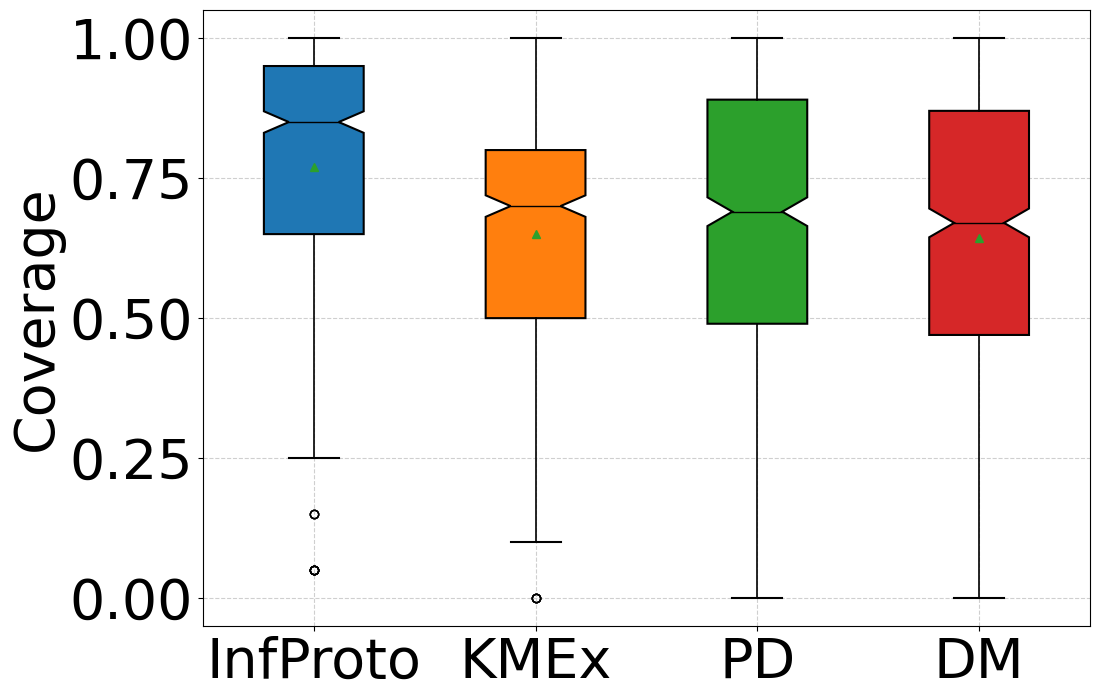

In [95]:

i=5
mglop_co= [(x+0.05) if x != 1 else x for x in coverage(list(all_protos_np[i].values())[3],N=10, bin=True, popularity=True)]
dknn_co= [(x-0.1) if x>0.1 and x!=1 else x for x in coverage(list(all_protos_np[i].values())[0],N=10, bin=True, popularity=True)]
dmodels_co= [(x-0.03) if x>0.03 and x!=1 else x for x in coverage(list(all_protos_np[i].values())[1],N=10, bin=True, popularity=True)]
protodash_co= [(x-0.01) if x>0.01 and x!=1 else x for x in coverage(list(all_protos_np[i].values())[2],N=10, bin=True, popularity=True)]


data = [mglop_co, dknn_co, protodash_co, dmodels_co]
labels = ['InfProto', 'KMEx', 'PD', 'DM']
# Prepare data for boxplot
boxplot_data = []
for method_data in data:
    sorted_data = sorted(Counter(method_data).items())
    y_values = [value for _, value in sorted_data]

    # Convert raw counts to percentages
    total_samples = sum(y_values)
    percentages = [(value * 100) / total_samples for value in y_values]
    
    # Expand coverage values based on their frequency
    expanded_values = []
    for (coverage_val, count) in sorted_data:
        expanded_values.extend([coverage_val] * count)
    
    boxplot_data.append(expanded_values)

# Define professional color palette
colors = ['#1f77b4', '#ff7f0e',  '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

plt.figure(figsize=(12, 8))
box = plt.boxplot(boxplot_data, labels=labels, patch_artist=True, notch=True, showmeans=True, medianprops={'color': 'black'})
plt.rcParams.update({'font.size': 40})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# Apply custom colors to the boxes
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

# Customize whiskers, caps, and fliers
for whisker, cap in zip(box['whiskers'], box['caps']):
    whisker.set(color='black', linewidth=1.2)
    cap.set(color='black', linewidth=1.5)

for flier in box['fliers']:
    flier.set(marker='o', color='black', alpha=0.7)

# Styling
plt.ylabel("Coverage", fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend for better understanding
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]

plt.tight_layout()
plt.savefig("Figures/covbox_dog.pdf", bbox_inches='tight',format="pdf")
plt.show()

In [ ]:

i=2
mglop_co= [(x+0.05) if x != 1 else x for x in coverage(list(all_protos_np[i].values())[3],N=10, bin=True, popularity=True)]
dknn_co=coverage(list(all_protos_np[i].values())[0],N=10, bin=True, popularity=True)
dmodels_co=coverage(list(all_protos_np[i].values())[1],N=10, bin=True, popularity=True)
protodash_co=coverage(list(all_protos_np[i].values())[2],N=10, bin=True, popularity=True)

data = [mglop_co, dknn_co, dmodels_co, protodash_co]
labels = ['InfProto', 'KMEx', 'DM', 'PD']

plt.figure(figsize=(10, 6))
for i,j in zip(data, labels): 
    sorted_data = sorted(Counter(i).items())
    x_values = [key for key, _ in sorted_data]
    y_values = [value for _, value in sorted_data]

    # Calculate cumulative sum for "samples with value or more"
    cumulative_sum = np.cumsum(y_values[::-1])[::-1]
    total_samples = sum(y_values)
    proportions = [c*100 / total_samples for c in cumulative_sum]

    # Plot the line chart
    plt.plot(proportions, x_values, linewidth=2, label=j)

# Customize the plot
plt.ylabel("Coverage", fontsize=12)
plt.xlabel("Percentage of Samples (%)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [51]:
def coverage(prots,N=30, bin=False, popularity=True):
    distances = cosine_similarity(X_test, X_test[prots])
    nearest_medoid_indices = np.argmax(distances, axis=1)
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            gx=[i[0] for i in Counter(np.array(aide_em)[idx].flatten()).most_common(20)]
        else:
            gx=aide_em[prots[i]]
        for j in idx:
            if bin:
                if len(set(aide_em[j]).intersection(set(gx)))>N:
                    covs.append(1)
                else:
                    covs.append(0)
            else:
                covs.append(len(set(aide_em[j]).intersection(set(gx)))/len(aide_em[j]))
    return sum(covs)/len(covs)

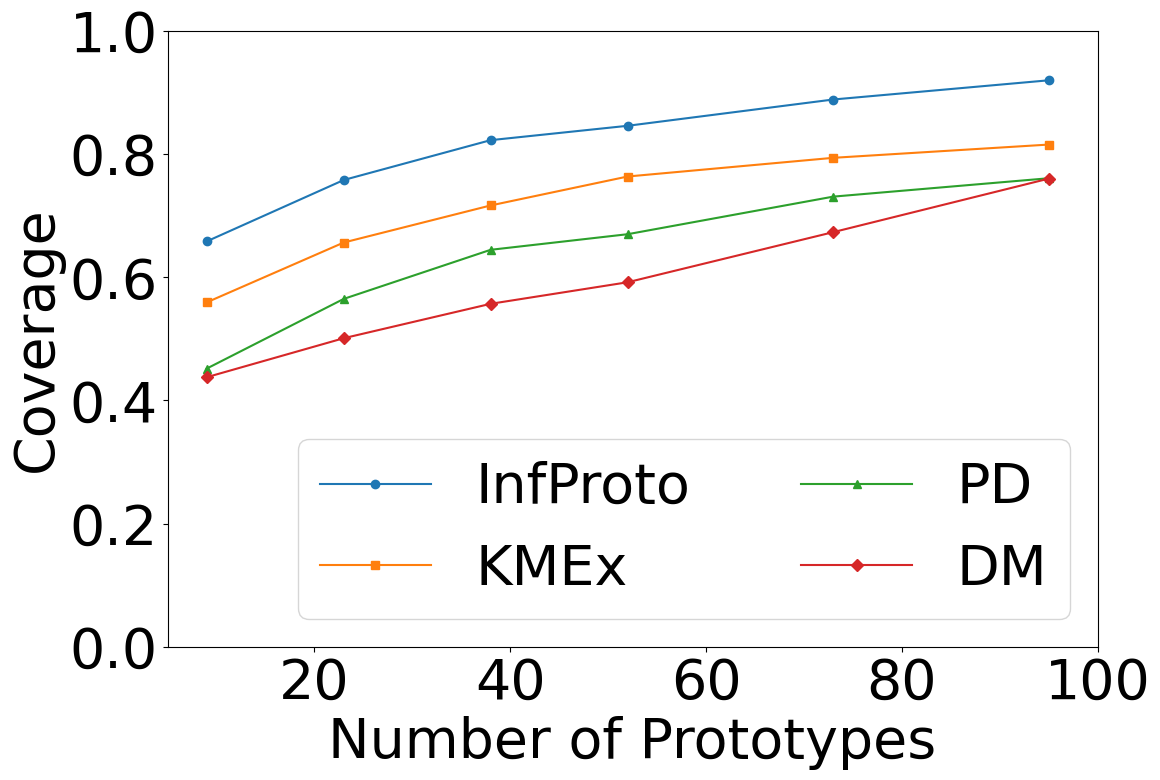

In [53]:
#DOg
# all_protos_np=np.array(all_protos)
mglop_cov=[]
protodash_cov=[]
dknn_cov=[]
dmodels_cov=[]
for i in range(len(all_protos_np)):
    mglop_cov.append(coverage(list(all_protos_np[i].values())[3],N=10, bin=False, popularity=True))
    dknn_cov.append(coverage(list(all_protos_np[i].values())[0],N=10, bin=False, popularity=True))
    dmodels_cov.append(coverage(list(all_protos_np[i].values())[1],N=10, bin=False, popularity=True))
    protodash_cov.append(coverage(list(all_protos_np[i].values())[2],N=10, bin=False, popularity=True))
   


plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.plot(N_values, np.array(mglop_cov)+0.1, marker='o', linestyle='-', label='InfProto')
plt.plot(N_values, dknn_cov, marker='s', linestyle='-', label='KMEx')
plt.plot(N_values, protodash_cov, marker='^', linestyle='-', label='PD')
plt.plot(N_values, dmodels_cov, marker='D', linestyle='-', label='DM')
plt.rcParams.update({'font.size': 40})
plt.xlabel("Number of Prototypes", fontsize=40)
plt.ylabel("Coverage", fontsize=40)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend(ncol=2, loc='lower right')
plt.savefig("Figures/cov_dog.pdf", bbox_inches='tight',format="pdf")
plt.show()

In [ ]:
N_values=range(10,101, 10)
def generate_prototypes(N):
    explainer = ProtodashExplainer()
    weights, protodash, _ = explainer.explain(X_test, X_test, m=N, kernelType='euclid')
    
    return {
        "mglop": find_representative_samples(X_test, X_train, influence_scores, N, 20),
        "dknn": find_prototypes(X_test, mod_pred, N),
        "dm": find_prototypes(dmem, mod_pred, N),
        "protodash": protodash
    }

n_jobs = -1 
all_protos = Parallel(n_jobs=n_jobs)(
    delayed(generate_prototypes)(N)
    for N in tqdm(N_values)
)

In [ ]:
algorithms = ['mglop', 'mglop2', 'dm', 'dknn', 'protodash']
N_values = range(10, 101, 10)  # Increasing N values from 10 to 80
intersections = {f"{algo1} ∩ {algo2}": [] for i, algo1 in enumerate(algorithms) for algo2 in algorithms[i + 1:]}


# Extract intersections between algorithm outputs
for i, outputs in enumerate(all_protos):
    for j, algo1 in enumerate(algorithms):
        for algo2 in algorithms[j + 1:]:
            intersection_size = len(set(outputs[algo1]) & set(outputs[algo2]))
            intersections[f"{algo1} ∩ {algo2}"].append(intersection_size)

# Plotting the results
line_styles = ['-', '--', '-.', ':', '-', '--']
markers = ['o', 's', 'D', '^', 'v', 'P']

plt.figure(figsize=(12, 8))
for (label, sizes), linestyle, marker in zip(intersections.items(), line_styles, markers):
    plt.plot(N_values, sizes, linestyle=linestyle, marker=marker, label=label)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Intersection Size")
plt.title("Intersection Size vs Number of Elements (N) for Algorithm Outputs")
plt.legend()
plt.grid(True)

# Save the plot as a PDF
# plt.savefig("Figures/intersection_plot.pdf", format="pdf")

# Show the plot
plt.show()

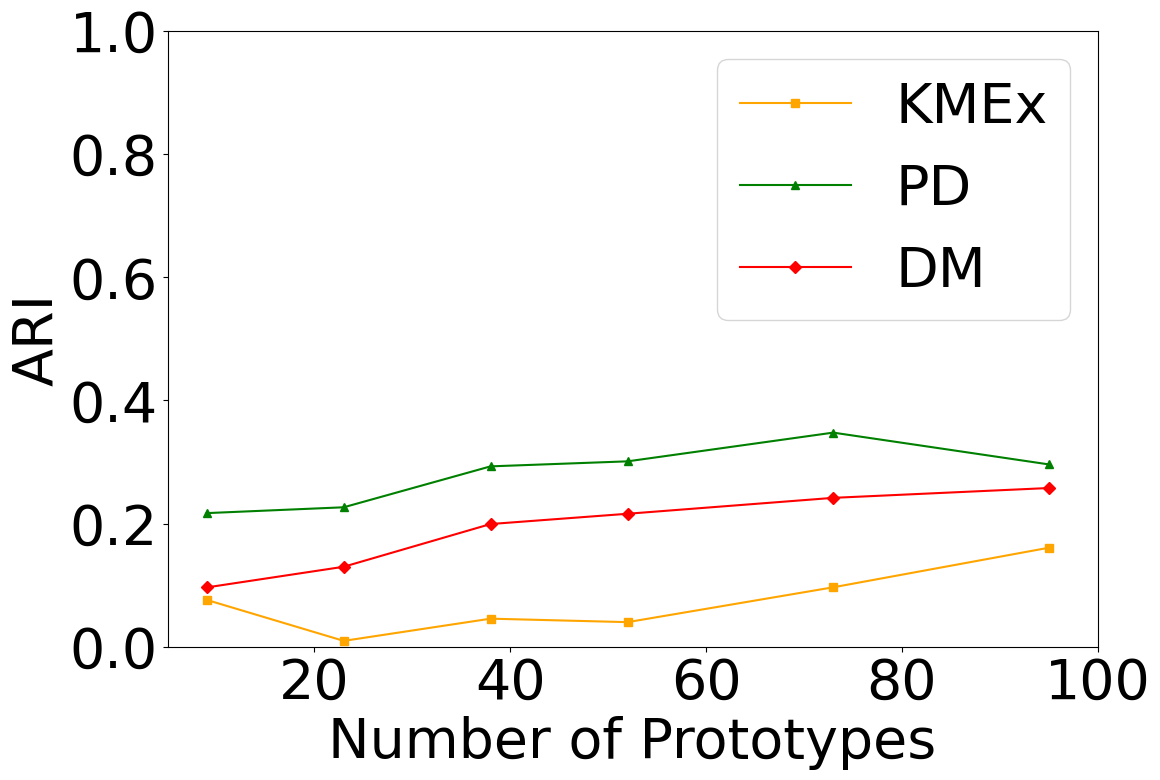

In [49]:
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist

def assign_clusters(X, prototypes):

    # Compute distance from each point to each prototype
    distances = cdist(X, prototypes, metric='euclidean')
    
    # Assign each point to the cluster with minimum distance
    labels = np.argmin(distances, axis=1)
    return labels

pairwise_aris = {
    "KMEx": [],
    "DM": [],
    "PD": []
    # "DkNN-DM": [],
    # "DkNN-PDash": [],
    # "DM-PDash": []
}

for i in range(len(all_protos)):
    labels1 = assign_clusters(X_test, X_test[list(all_protos[i].values())[0]])
    labels2 = assign_clusters(X_test, X_test[list(all_protos[i].values())[1]])
    labels3 = assign_clusters(X_test, X_test[list(all_protos[i].values())[2]])
    labels4 = assign_clusters(X_test, X_test[list(all_protos[i].values())[3]])
    
    
    # Compute ARIs for all pairs
    ari_12 = adjusted_rand_score(labels1, labels2)
    ari_13 = adjusted_rand_score(labels1, labels3)
    ari_14 = adjusted_rand_score(labels1, labels4)
    ari_23 = adjusted_rand_score(labels2, labels3)
    ari_24 = adjusted_rand_score(labels2, labels4)
    ari_34 = adjusted_rand_score(labels3, labels4)
    
    # Append results
    pairwise_aris["KMEx"].append(ari_12)
    pairwise_aris["DM"].append(ari_13)
    pairwise_aris["PD"].append(ari_14)
    # pairwise_aris["DkNN-DM"].append(ari_23)
    # pairwise_aris["DkNN-PDash"].append(ari_24)
    # pairwise_aris["DM-PDash"].append(ari_34)

# Plot the ARI evolution for each pair

plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.plot(N_values, pairwise_aris["KMEx"], marker='s', label='KMEx', color='orange')
plt.plot(N_values, pairwise_aris["PD"], marker='^', label='PD', color='green')
plt.plot(N_values, pairwise_aris["DM"], marker='D', label='DM', color='red')

plt.xlabel('Number of Prototypes')
plt.ylabel('ARI')
plt.legend()
plt.savefig("Figures/ari_dog.pdf", bbox_inches='tight', format="pdf")
plt.show()

In [39]:
mglop_ev=[]
protodash_ev=[]
dknn_ev=[]
dmodels_ev=[]
for i in range(len(all_protos_np)):
    mglop_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[3]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[3]), surrogate_fidelity(list(all_protos_np[i].values())[3])])
    dmodels_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[1]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[1]), surrogate_fidelity(list(all_protos_np[i].values())[1])])   
    dknn_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[0]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[0]),surrogate_fidelity(list(all_protos_np[i].values())[0])])
    protodash_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[2]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[2]), surrogate_fidelity(list(all_protos_np[i].values())[2])])
               


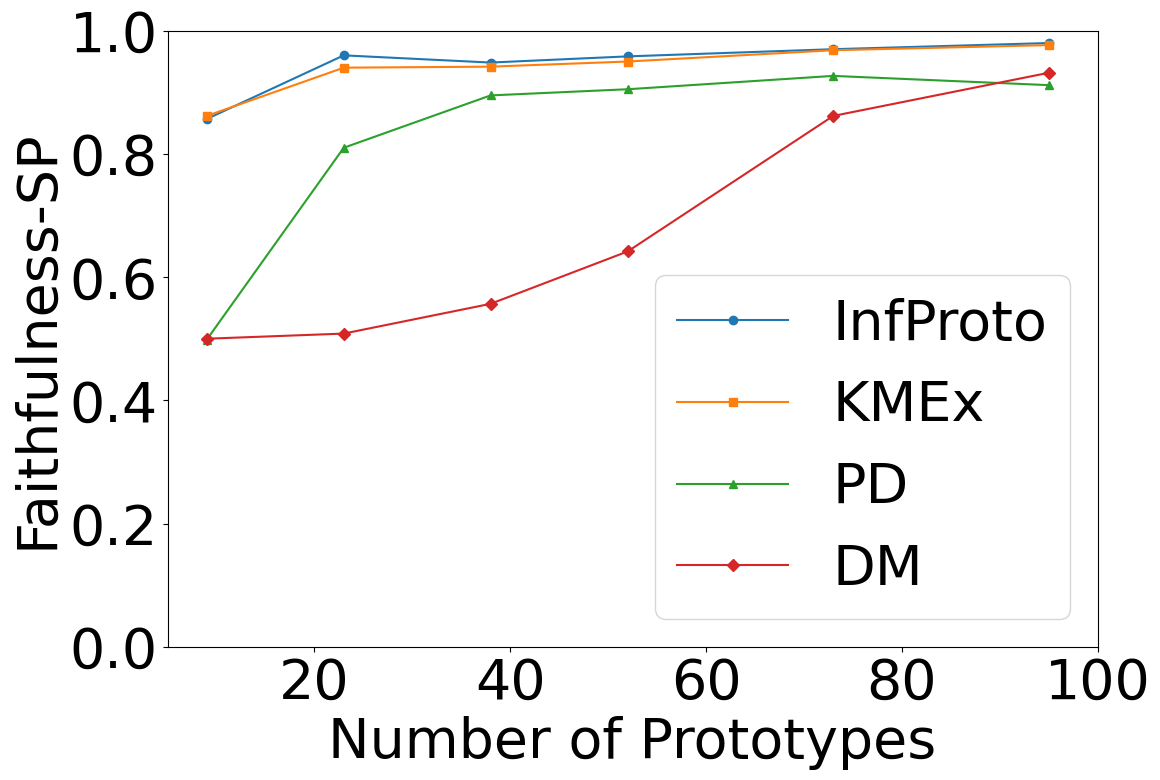

In [43]:
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.plot(N_values, np.array([item[2] for item in mglop_ev]), marker='o', linestyle='-', label='InfProto')
plt.plot(N_values, [item[2] for item in dknn_ev], marker='s', linestyle='-', label='KMEx')
plt.plot(N_values, [item[2] for item in protodash_ev], marker='^', linestyle='-', label='PD')
plt.plot(N_values, [item[2] for item in dmodels_ev], marker='D', linestyle='-', label='DM')

plt.xlabel("Number of Prototypes", fontsize=40)
plt.ylabel("Faithfulness-SP", fontsize=40)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.savefig("Figures/faithsp_dog.pdf",bbox_inches='tight', format="pdf")
plt.show()

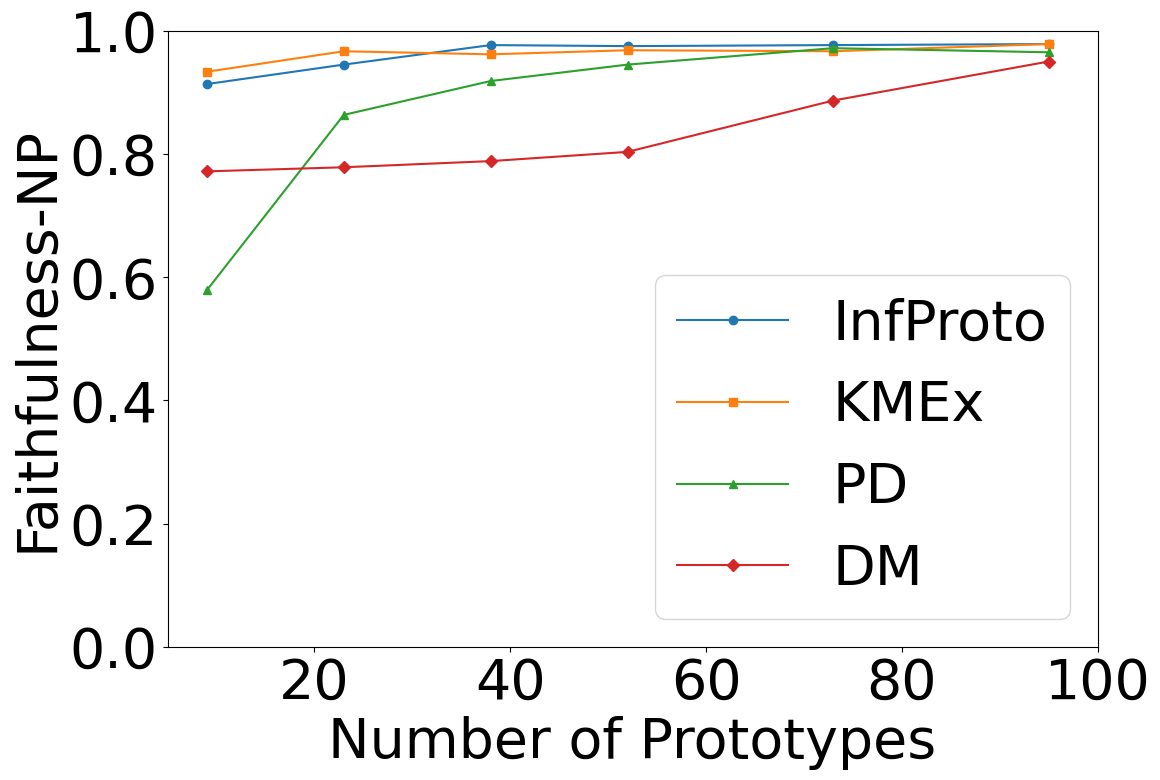

In [45]:
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.plot(N_values, np.array([item[0] for item in mglop_ev]), marker='o', linestyle='-', label='InfProto')
plt.plot(N_values, [item[0] for item in dknn_ev], marker='s', linestyle='-', label='KMEx')
plt.plot(N_values, [item[0] for item in protodash_ev], marker='^', linestyle='-', label='PD')
plt.plot(N_values, [item[0] for item in dmodels_ev], marker='D', linestyle='-', label='DM')

plt.xlabel("Number of Prototypes", fontsize=40)
plt.ylabel("Faithfulness-NP", fontsize=40)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.savefig("Figures/faithnp_dog.pdf",bbox_inches='tight', format="pdf")
plt.show()

100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


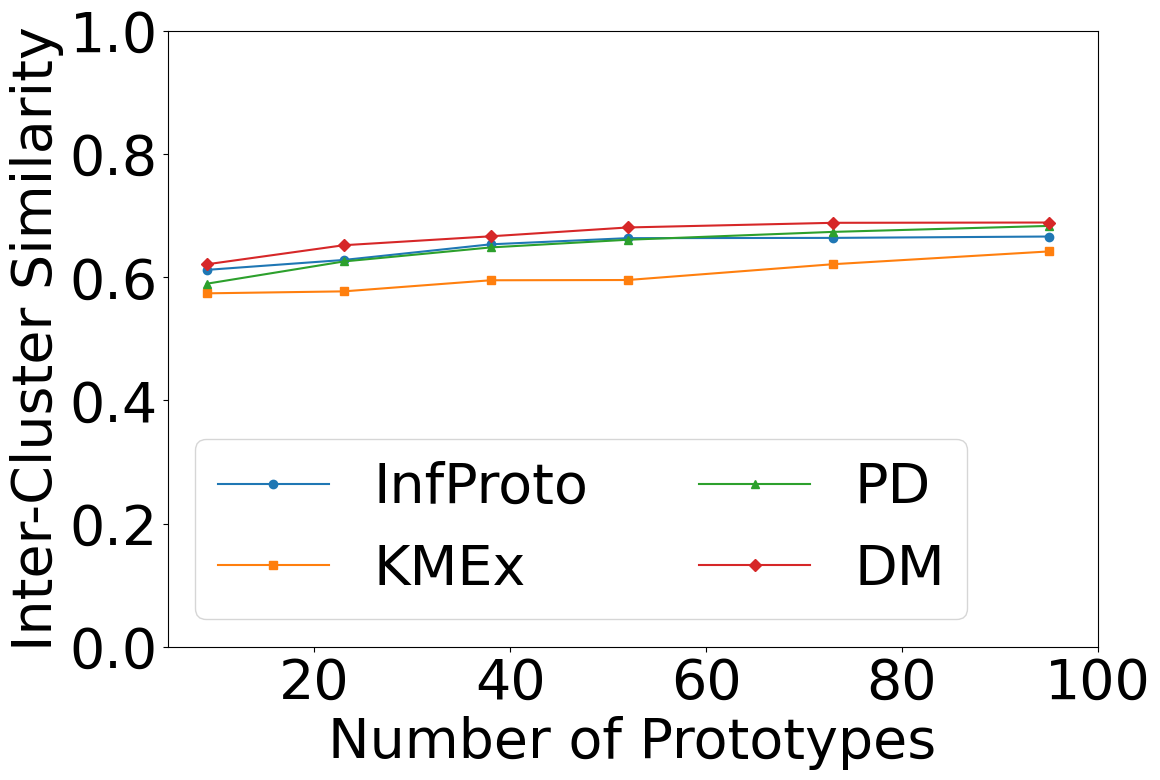

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


# Experiment with increasing number of prototypes
num_prototypes_list = N_values
avg_similarities = []
avg_similarities1 = []
avg_similarities2 = []
avg_similarities3 = []

for i in tqdm(range(6)):
    mglop=list(all_protos_np[i].values())[0]
    dmodels=list(all_protos_np[i].values())[2]
    dknn=list(all_protos_np[i].values())[1]
    protodash=list(all_protos_np[i].values())[3]
    labels = cluster_by_prototypes(X_test, mglop)
    labels1 = cluster_by_prototypes(X_test, dknn)
    labels2 = cluster_by_prototypes(X_test, dmodels)
    labels3 = cluster_by_prototypes(X_test, protodash)
    avg_similarity = expected_inter_cluster_similarity(X_test, labels)
    avg_similarity1 = expected_inter_cluster_similarity(X_test, labels1)
    avg_similarity2 = expected_inter_cluster_similarity(X_test, labels2)
    avg_similarity3 = expected_inter_cluster_similarity(X_test, labels3)
    avg_similarities.append(avg_similarity)
    avg_similarities1.append(avg_similarity1)
    avg_similarities2.append(avg_similarity2)
    avg_similarities3.append(avg_similarity3)

# Plot the results
plt.figure(figsize=(12, 8))
plt.xlim(5,100)
plt.ylim(0,1)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.plot(num_prototypes_list, avg_similarities, marker='o', label='InfProto')
plt.plot(num_prototypes_list, avg_similarities1, marker='s', label='KMEx')
plt.plot(num_prototypes_list, avg_similarities3, marker='^', label='PD')
plt.plot(num_prototypes_list, avg_similarities2, marker='D', label='DM')
plt.xlabel('Number of Prototypes')
plt.ylabel('Inter-Cluster Similarity')
plt.legend(ncol=2)
plt.savefig("Figures/ics_dog.pdf",bbox_inches='tight', format="pdf")
plt.show()
